In [1]:
%load_ext autoreload
%autoreload 2
%cd ..

/home/daniel/Documents/dark-matter-halos/src


In [2]:
from classical.classical_approach import *
from knn import knn
import numpy as np
from dataclasses import dataclass
from jax import typing, Array

root_path = Path().resolve().parents[0]
data_path = root_path / "data"
halos_path = data_path / "halos.pkl"


In [3]:
data = load_data(data_path)

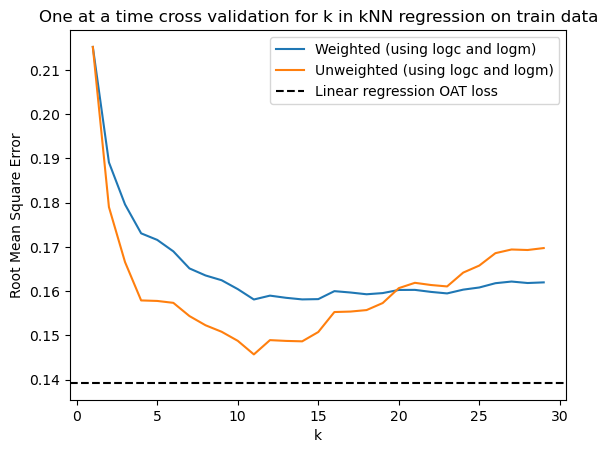

In [4]:
def oat_cross_validation(
    train_predictors: typing.ArrayLike, train_labels: typing.ArrayLike, **kwargs
) -> jnp.array:
    distance_matrix = jnp.linalg.norm(
        train_predictors[:, None] - train_predictors[None], axis=-1
    )
    n_train = len(train_predictors)
    residuals = []

    for i in range(n_train):
        residual = train_labels[i] - knn.regression2(
            jnp.delete(train_labels, i),
            distance_matrix,
            jnp.delete(jnp.arange(n_train), i),
            jnp.array([i]),
            **kwargs
        )
        residuals.append(residual)
        

    return jnp.sqrt(jnp.mean(jnp.square(jnp.array(residuals))))



ks = np.arange(1, 30)

weighted_scores = [oat_cross_validation(data["train_predictors"], data["train_labels"], k=k, weighted=True) for k in ks]
unweighted_scores = [oat_cross_validation(data["train_predictors"], data["train_labels"], k=k, weighted=False) for k in ks]


fig, ax = plt.subplots()

ax.plot(ks, weighted_scores, label="Weighted (using logc and logm)")
ax.plot(ks, unweighted_scores, label="Unweighted (using logc and logm)")
ax.axhline(y=0.13923663, color="black", linestyle="--", label="Linear regression OAT loss")
ax.set(ylabel="Root Mean Square Error", xlabel="k", title="One at a time cross validation for k in kNN regression on train data")
plt.legend()